In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import hashlib
from absl import logging
import tensorflow as tf
import lxml.etree
import tqdm
import xml.etree.cElementTree as ET
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
import yaml

# Data preparation

In [3]:
import pandas as pd

with open('annotations_1.txt', 'r') as file:
    lines = file.readlines()

data = [line.strip().split(':', 1) for line in lines]
data_split = [(line[0],) + tuple(line[1].split(';')) for line in data]

expanded_data = []
for row in data_split:
    image_path = row[0]
    for sign_info in row[1:]:
        sign_data = sign_info.split(',')
        expanded_data.append((image_path,) + tuple(sign_data))

max_columns = max(len(row) for row in expanded_data)
columns = [f"col_{i}" for i in range(max_columns)]

data = pd.DataFrame(expanded_data, columns=columns)
data = data.iloc[:, :8]
new_column_names = ['path', 'state', 'left', 'top', 'right', 'bottom', 'category', 'sign']
data.columns = new_column_names
data['state'] = data['state'].replace('', None)
data['sign'] = data['sign'].str.rstrip(';')
data = data.dropna(subset=['sign'])
data.reset_index(drop=True, inplace=True)
data.head(10)

,path,state,left,top,right,bottom,category,sign
0,1277381655Image000002.jpg,BLURRED,547.856366,534.637640,521.545082,509.470324,INFORMATION,PRIORITY_ROAD
1,1277381655Image000007.jpg,BLURRED,566.874451,534.587056,538.217824,506.358141,INFORMATION,PRIORITY_ROAD
2,1277381655Image000012.jpg,VISIBLE,615.349298,510.079008,580.346221,475.962085,INFORMATION,PRIORITY_ROAD
3,1277381655Image000017.jpg,VISIBLE,734.514285,476.071103,682.706066,428.440966,INFORMATION,PRIORITY_ROAD
4,1277381655Image000022.jpg,VISIBLE,915.566823,426.185815,840.566823,349.185815,INFORMATION,PRIORITY_ROAD
5,1277381671Image000002.jpg,BLURRED,656.124924,568.720854,638.753875,551.832335,MANDATORY,PASS_EITHER_SIDE
6,1277381671Image000007.jpg,BLURRED,638.041940,571.188265,619.245140,551.821865,MANDATORY,PASS_EITHER_SIDE
7,1277381671Image000012.jpg,BLURRED,605.060347,567.653050,586.692347,547.973050,MANDATORY,PASS_EITHER_SIDE
8,1277381674Image000001.jpg,VISIBLE,432.168746,573.905720,393.149818,533.126540,MANDATORY,PASS_EITHER_SIDE
9,1277381674Image000001.jpg,OCCLUDED,436.049047,589.307319,414.015810,566.716278,MANDATORY,PASS_RIGHT_SIDE


(960, 1280, 3)


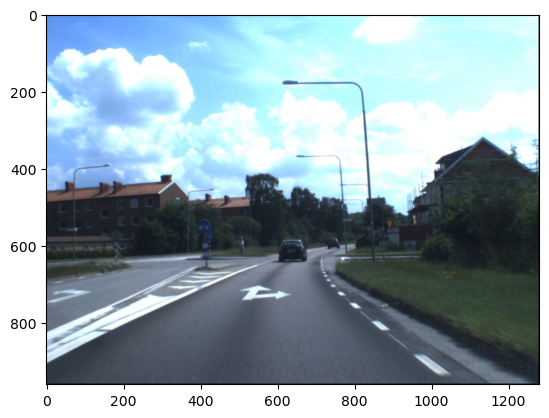

In [76]:
img = Image.open('C:\\Users\\Tseh\\Documents\\YOLO\\swedish_signs\\'+data['path'][10])
plt.imshow(img)
img=np.array(img)
print(img.shape)

In [61]:
import pandas as pd
import os
df = pd.DataFrame(data)


folder_path = 'C:\\Users\\Tseh\\Documents\\YOLO\\swedish_signs\\'

for index, row in df.iterrows():
    image_path = os.path.join(folder_path, row['path'])
    if row['sign'] is None and os.path.exists(image_path):
        os.remove(image_path)
        print(f"Deleted: {row['path']}")

print("Deletion process completed.")

Deleted: 1277381619Image000001.jpg
Deleted: 1277381619Image000006.jpg
Deleted: 1277381619Image000011.jpg
Deleted: 1277381619Image000016.jpg
Deleted: 1277381624Image000002.jpg
Deleted: 1277381624Image000007.jpg
Deleted: 1277381624Image000012.jpg
Deleted: 1277381624Image000017.jpg
Deleted: 1277381680Image000014.jpg
Deleted: 1277381708Image000017.jpg
Deleted: 1277381708Image000022.jpg
Deleted: 1277381750Image000004.jpg
Deleted: 1277381750Image000009.jpg
Deleted: 1277381750Image000014.jpg
Deleted: 1277381750Image000019.jpg
Deleted: 1277381792Image000001.jpg
Deleted: 1277381792Image000006.jpg
Deleted: 1277381792Image000011.jpg
Deleted: 1277381940Image000004.jpg
Deleted: 1277381940Image000009.jpg
Deleted: 1277381940Image000014.jpg
Deleted: 1277381949Image000023.jpg
Deleted: 1277382118Image000011.jpg
Deleted: 1277382258Image000004.jpg
Deleted: 1277382258Image000009.jpg
Deleted: 1277382258Image000014.jpg
Deleted: 1277382385Image000018.jpg
Deleted: 1277382390Image000004.jpg
Deleted: 1277382390I

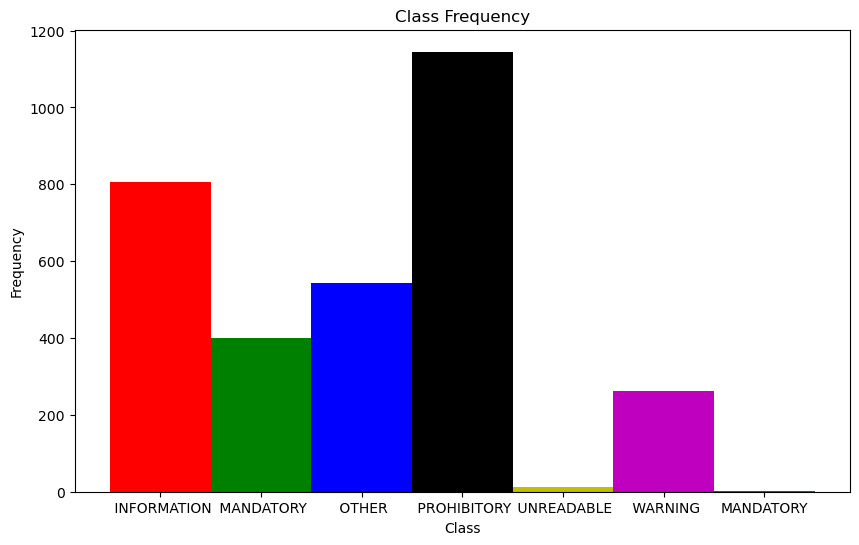

In [77]:
filtered_data = data[data['category'].notnull()]
unique, counts = np.unique(filtered_data['category'], return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, 1, color=list('rgbkym'))
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [89]:
def annotate_picture(picture_num):
    image_path = 'C:\\Users\\Tseh\\Documents\\YOLO\\swedish_signs\\' + data['path'].iloc[picture_num]  
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    left = float(data.iloc[picture_num]['left'])
    top = float(data.iloc[picture_num]['top'])
    right = float(data.iloc[picture_num]['right'])
    bottom = float(data.iloc[picture_num]['bottom'])
    draw.rectangle([(left, top), (right, bottom)], outline='red')
    label = f"{data['sign'].iloc[picture_num]}"
    font = ImageFont.truetype("arial.ttf", size=20)  
    draw.text((left, top - 30), label, fill='red', font=font)
    image.show()
annotate_picture(10)

In [90]:
from PIL import Image, ImageDraw, ImageFont
import os

output_folder = 'C:\\Users\\Tseh\\Documents\\YOLO\\swedish_signs_annotated\\'
os.makedirs(output_folder, exist_ok=True)

def annotate_picture(picture_num):
    image_path = 'C:\\Users\\Tseh\\Documents\\YOLO\\swedish_signs\\' + data['path'].iloc[picture_num]
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    left = float(data.iloc[picture_num]['left'])
    top = float(data.iloc[picture_num]['top'])
    right = float(data.iloc[picture_num]['right'])
    bottom = float(data.iloc[picture_num]['bottom'])
    draw.rectangle([(left, top), (right, bottom)], outline='red')
    label = f"{data['sign'].iloc[picture_num]}"
    font = ImageFont.truetype("arial.ttf", size=20)
    draw.text((left, top - 30), label, fill='red', font=font)
    return image
for i in range(len(data)):
    annotated_image = annotate_picture(i)
    annotated_image.save(f"{output_folder}{i+1}.jpg")

In [25]:
len(df)

3169

In [4]:
df = pd.read_csv('C:\\Users\\Tseh\\Documents\\YOLO\\swedish_signs_dataset_1')

In [8]:
df['sign'].value_counts()

sign
 OTHER                      543
 PRIORITY_ROAD              470
 PASS_RIGHT_SIDE            351
 PEDESTRIAN_CROSSING        337
 GIVE_WAY                   261
 70_SIGN                    255
 50_SIGN                    223
 80_SIGN                    106
 110_SIGN                    98
 120_SIGN                    92
 100_SIGN                    77
 NO_STOPPING_NO_STANDING     77
 90_SIGN                     64
 60_SIGN                     48
 30_SIGN                     45
 NO_PARKING                  39
 PASS_EITHER_SIDE            31
 STOP                        21
 PASS_LEFT_SIDE              19
 URDBL                       12
Name: count, dtype: int64